# Analysis of Solar Cells

TBD

In [1]:
import jax.numpy as jnp
import numpy as onp
import matplotlib.pyplot as plt

import jaxlayerlumos as jll
import jaxlayerlumos.utils_units as jll_utils_units
import jaxlayerlumos.utils_materials as jll_utils_materials
import jaxlayerlumos.utils_spectra as jll_utils_spectra
import jaxlayerlumos.utils_position as jll_utils_position

In [2]:
c = jll_utils_units.get_light_speed()
h = jll_utils_units.get_planck_constant()
e = jll_utils_units.get_elementary_charge()
nano = jll_utils_units.get_nano()

print(f"Light speed: {c}")
print(f"Planck constant: {h}")
print(f"Elementary charge: {e}")
print(f"nano: {nano}")

Light speed: 299792458.0
Planck constant: 6.62607015e-34
Elementary charge: 1.602176634e-19
nano: 1e-09


## Silicon Absorption on PEC

Crystalline silicon is the most common material for solar cells.  In this example, we simulate 150 micron thick silicon on a perfectly electrical conductor (PEC) and make a plot of the absorption spectra.
Since crystalline silicon has a bandgap of 1.12 eV, you can see that the silicon only absorbs at photon energies greater than 1.12 eV.

In [3]:
wavelengths = jnp.linspace(280, 2000, 1000) * nano
frequencies = jll_utils_spectra.convert_wavelengths_to_frequencies(wavelengths)
energy = jll_utils_spectra.convert_wavelengths_to_energy(wavelengths)

materials = ["Air", "cSi", "PEC"]
thicknesses = jnp.array([0, 40e-6, 0])
inc_angle = 0.0

n_k = jll_utils_materials.get_n_k(materials, frequencies)
R_TE, T_TE, R_TM, T_TM = jll.stackrt(n_k, thicknesses, frequencies, inc_angle)

A = 1 - R_TE.squeeze() - T_TE.squeeze()

/bgfs/pleu/juk139/workspace/JaxLayerLumos/jaxlayerlumos/utils_materials.py:118: UserWarning: Extrapolation detected: Some frequencies are outside the given data range.
  warnings.warn(
/bgfs/pleu/juk139/workspace/JaxLayerLumos/jaxlayerlumos/utils_materials.py:118: UserWarning: Extrapolation detected: Some frequencies are outside the given data range.
  warnings.warn(


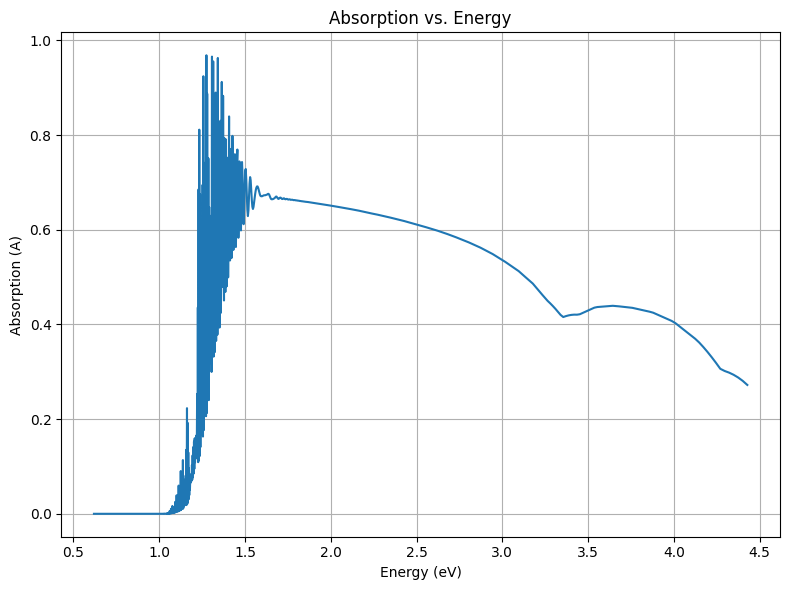

In [4]:
fig = plt.figure(figsize=(8, 6))
ax = fig.gca()

ax.plot(energy, A)
ax.set_xlabel("Energy (eV)")
ax.set_ylabel("Absorption (A)")
ax.set_title("Absorption vs. Energy")
ax.grid()

plt.tight_layout()
plt.show()

## Silicon Absorption on Aluminum

Here we switch the back layer to Aluminum instead of a perfect electrical conductor (PEC).  Since the Aluminum has some parasitic absorption, we must calculate the absorption in each layer.
There is a very slight difference with aluminum, but it is small so we can just use PEC. As can be seen, most of the absorption in the aluminum occurs at smaller energies and thus can be absorbed.

In [5]:
wavelengths = jnp.linspace(280, 2000, 1000) * nano
frequencies = jll_utils_spectra.convert_wavelengths_to_frequencies(wavelengths)
energy = jll_utils_spectra.convert_wavelengths_to_energy(wavelengths)

materials = ["Air", "cSi", "Al"]
thicknesses = jnp.array([0, 40e-6, 0])
material_silicon_index = 2
material_aluminum_index = 3

n_k = jll_utils_materials.get_n_k(materials, frequencies)
inc_angle = 0.0

R_TE, T_TE, R_TM, T_TM, results_coeffs = jll.stackrt(
    n_k, thicknesses, frequencies, inc_angle, return_coeffs=True
)

results_coeffs = jll_utils_position.calc_absorption_in_each_layer(
    thicknesses, results_coeffs
)
# results_coeffs["absorption_layer_TE"][material_silicon_index-1,:]

/bgfs/pleu/juk139/workspace/JaxLayerLumos/jaxlayerlumos/utils_materials.py:118: UserWarning: Extrapolation detected: Some frequencies are outside the given data range.
  warnings.warn(


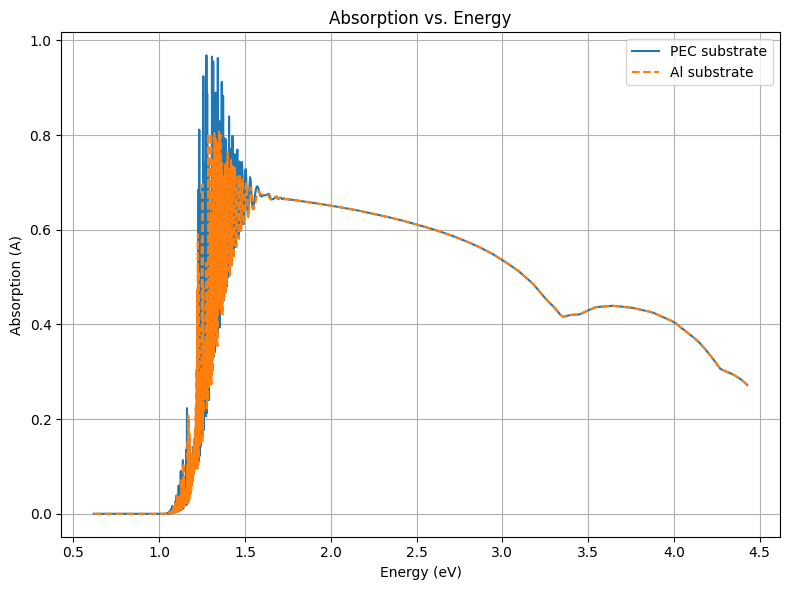

In [6]:
fig = plt.figure(figsize=(8, 6))
ax = fig.gca()

ax.plot(energy, A, label='PEC substrate', linestyle='solid')
ax.plot(energy, results_coeffs["absorption_layer_TE"][material_silicon_index-1,:], label='Al substrate', linestyle='dashed')
ax.set_xlabel("Energy (eV)")
ax.set_ylabel("Absorption (A)")
ax.set_title("Absorption vs. Energy")
ax.grid()

plt.legend()
plt.tight_layout()
plt.show()

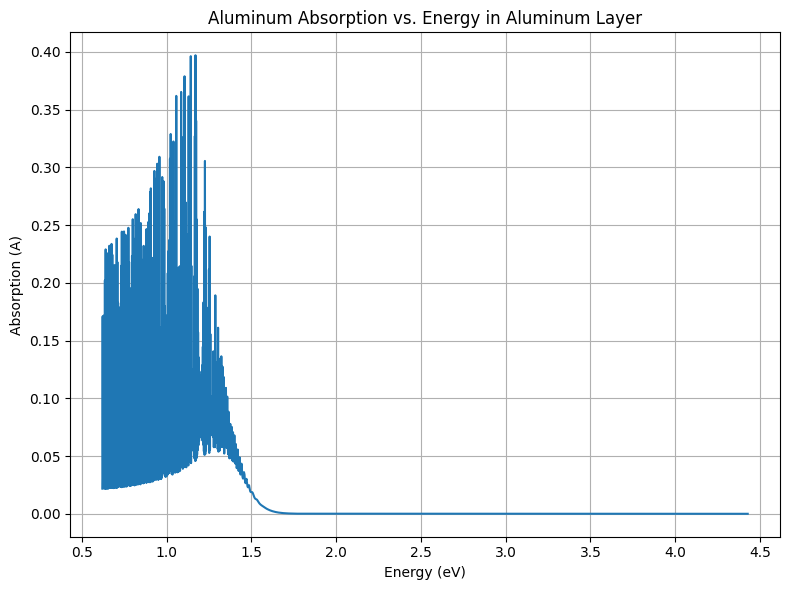

In [7]:
fig = plt.figure(figsize=(8, 6))
ax = fig.gca()

ax.plot(energy, results_coeffs["absorption_layer_TE"][material_aluminum_index-1,:], label='Al substrate Absorption')
ax.set_xlabel("Energy (eV)")
ax.set_ylabel("Absorption (A)")
ax.set_title("Aluminum Absorption vs. Energy in Aluminum Layer")
ax.grid()

plt.tight_layout()
plt.show()

In [8]:
wavelengths_all = jnp.linspace(280e-9, 4000e-9, 2000)
wavelengths_all_nm = jll_utils_units.convert_m_to_nm(wavelengths_all)
irradiance_all = utils_spectra.get_irradiance('AM1p5G', wavelengths_all)
photon_flux_all = (irradiance_all * wavelengths_all)/(scic.h*scic.c)
total_photons = onp.trapezoid(photon_flux_all, wavelengths_all_nm)

NameError: name 'utils_spectra' is not defined

## Solar Absorption

We want to calculate the solar absorption as a function of thickness. The solar absorption is defined as the fraction of photons absorbed divided by the total number of photons.  We use the AM1.5G spectra here.

In [ ]:
wavelengths = jnp.linspace(280e-9, 1400e-9, 1000)
energy = utils_spectra.convert_wavelengths_to_energy(wavelengths)

frequencies = scic.c / wavelengths

silicon_thicknesses = jnp.linspace(100e-9, 100e-6, 100)
# PEC is a perfect electrical conductor
materials = onp.array(["Air", "cSi", "PEC"])

solar_absorption_results = []

n_k = utils_materials.get_n_k(materials, frequencies)

irradiance = utils_spectra.get_irradiance('AM1p5G', wavelengths)
photon_flux = (irradiance * wavelengths) / (scic.h * scic.c)

absorption_results = onp.zeros((len(silicon_thicknesses), len(wavelengths)))

for i, thickness_si in enumerate(silicon_thicknesses):

    thickness_materials = [0, thickness_si, 0]

    thicknesses = jnp.array(thickness_materials)

    R_TE, T_TE, R_TM, T_TM = jll.stackrt(n_k, thicknesses, frequencies, 0.0)
    A = 1 - R_TE - T_TE
    absorption_results[i,:] = A
    solar_absorption = onp.trapezoid(A * photon_flux, wavelengths) / total_photons
    solar_absorption_results.append(solar_absorption)

solar_absorption_results = onp.array(solar_absorption_results)

silicon_thicknesses_micron = jll_utils_units.convert_m_to_um(silicon_thicknesses)

plt.figure(figsize=(8, 6))
plt.plot(silicon_thicknesses_micron, solar_absorption_results, label='Solar Absorption', color="b")
# plt.plot(energy, A.squeeze(), label="Absorption (A)", color="b")
plt.xlabel("Silicon Thickness (um)")
plt.ylabel("Solar Absorption (A)")
plt.title("Solar Absorption vs. Silicon Thickness")
plt.grid(True)

X, Y = onp.meshgrid(energy, silicon_thicknesses_micron)
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, absorption_results, levels=100, cmap = 'jet')
plt.colorbar(label='Absorption')
plt.xlabel('Energy (eV)')
plt.ylabel('Silicon Thickness (µm)')
plt.title('Absorption vs. Energy and Silicon Thickness')
plt.grid()
plt.show()

## Ultrathin silicon example

There is interest in using ultrathin silicon for solar cells. Since silicon is an indirect band gap material, a number of approaches have been used to trap light in the silicon and increase absorption.  Here, we simulate the absorption of ultrathin silicon.  The leaky resonance modes in the crystalline silicon films can be observed.

[1] B. Wang, T. Gao, Z. Zhou, B. Pafchek, and P. W. Leu, “Frontside scattering structures for enhanced performance in flexible ultrathin crystalline silicon solar cells,” JPE, vol. 8, no. 3, p. 030501, Sep. 2018, doi: 10.1117/1.JPE.8.030501
https://doi.org/10.1117/1.JPE.8.030501

[2] B. Wang, T. Gao, and P. W Leu, “Broadband light absorption enhancement in ultrathin film crystalline silicon solar cells with high index of refraction nanosphere arrays,” Nano Energy, vol. 19, pp. 471–475, Jan. 2016, doi: 10.1016/j.nanoen.2015.10.039
https://doi.org/10.1016/j.nanoen.2015.10.039

[3] T. Gao, B. Wang, and P. W. Leu, “Plasmonic nanomesh sandwiches for ultrathin film silicon solar cells,” J. Opt., vol. 19, no. 2, p. 025901, Dec. 2016, doi: 10.1088/2040-8986/19/2/025901
https://doi.org/10.1088/2040-8986/19/2/025901



In [ ]:
silicon_thicknesses_nm = jnp.linspace(100.0, 1000.0, 100)
silicon_thicknesses = jll_utils_units.convert_nm_to_m(silicon_thicknesses_nm)

materials = onp.array(["Air", "cSi", "PEC"])
absorption_spectra = []

wavelengths = jnp.linspace(280e-9, 1200e-9, 1000)
frequencies = scic.c / wavelengths
irradiance = utils_spectra.get_irradiance('AM1p5G', wavelengths)

photon_flux = (irradiance * wavelengths) / (scic.h * scic.c)
energy = utils_units.get_light_speed() * scic.h / wavelengths / scic.e

n_k = utils_materials.get_n_k(materials, frequencies)

wavelengths_all = jnp.linspace(280e-9, 4000e-9, 2000)
irradiance_all = utils_spectra.get_irradiance('AM1p5G', wavelengths_all)
photon_flux_all = (irradiance_all * wavelengths_all)/(scic.h*scic.c)
total_photons = onp.trapezoid(photon_flux_all, wavelengths_all)

solar_absorption_results = []

for i, thickness_si in enumerate(silicon_thicknesses):
    thickness_materials = [0, thickness_si, 0]
    thicknesses = jnp.array(thickness_materials)

    R_TE, T_TE, R_TM, T_TM = jll.stackrt(n_k, thicknesses, frequencies, 0.0)
    A = 1 - R_TE - T_TE
    absorption_spectra.append(onp.array(A))
    solar_absorption = onp.trapezoid(A * photon_flux, wavelengths)/total_photons
    solar_absorption_results.append(solar_absorption)

solar_absorption_results = onp.array(solar_absorption_results)


# Convert the list of spectra into a 2D NumPy array.
# The resulting array has shape: (num_silicon_thicknesses, num_wavelengths)
absorption_spectra = onp.array(absorption_spectra).squeeze()

# plot silicon thickness
silicon_thicknesses_nm = jll_utils_units.convert_m_to_nm(silicon_thicknesses)

plt.figure(figsize=(8, 6))
plt.plot(silicon_thicknesses_nm, solar_absorption_results, label='Solar Absorption', color="b")
# plt.plot(energy, A.squeeze(), label="Absorption (A)", color="b")
plt.xlabel("Silicon Thickness (nm)")
plt.ylabel("Solar Absorption (A)")
plt.title("Solar Absorption vs. Silicon Thickness")
plt.grid(True)


# Plot the absorption map as a function of wavelength and silicon thickness.
plt.figure(figsize=(8, 6))
X, Y = onp.meshgrid(onp.array(jll_utils_units.convert_m_to_nm(wavelengths)), silicon_thicknesses_nm)
pcm = plt.pcolormesh(X, Y, absorption_spectra, shading='auto', cmap='jet')
plt.colorbar(pcm, label="Absorption")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Silicon Thickness (nm)")
plt.title("Absorption Spectrum for Si at Normal Incidence")
plt.tight_layout()
plt.show()